In [3]:
import pickle
import numpy as np
from math import comb, prod

from matplotlib import cm as cmp
import matplotlib.pyplot as plt
import matplotlib.colors as clr

In [4]:
# Figure settings
FIG_HEIGHT, FIG_WIDTH = 3.5, 3.5 # inches

latex_preamble = [
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
]

plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "text.latex.preamble": "".join(latex_preamble)
})

In [5]:
# Utilities
def shuffled_hand(S,C,N):
    '''
    Returns a hand and remaining deck for N players from a shuffled deck with C valued cards and S suites.
    '''
    card_values   = np.arange(1,C+1, dtype=np.int8)
    ordered_deck  = np.repeat(card_values,S)
    shuffled_deck = np.random.permutation(ordered_deck)
    return shuffled_deck[:N], shuffled_deck[N:]

def table_view(hand,C): 
    '''
    Returns the table view: covered cards are denoted with 0s, C and C-1 valued card with their value.
    '''
    table = np.zeros_like(hand, dtype=np.int8)
    uncovered = np.logical_or(hand==C, hand==C-1)
    table[uncovered] = hand[uncovered]
    return table

def ff(x,k):
    '''
    Returns the falling factorial of x up to k
    '''
    return prod([i for i in range(x-k+1,x+1)])

def vm(v,S):
    '''
    Returns the number of cards in the deck valued less than v
    '''
    return S*(v - 1)

def vp(v,S,C):
    '''
    Returns the number of cards in the deck valued greater than v
    '''
    return S*(C - v)

def vme(v,S):
    '''
    Returns the number of cards in the deck valued less or equal than v
    '''
    return vm(v,S) + S

def vpe(v,S,C):
    '''
    Returns the number of cards in the deck valued greater or equal than v
    '''
    return vp(v,S,C) + S

def p_omega_null(v, S, C, N, Kpe):
    '''
    Returns the probability of winning (i.e, not to be the player with the lowest valued card) in case of not exchanging
    '''
    M = min(vm(v,S), N - Kpe)
    return sum([comb(N-Kpe, n)*(ff(vm(v,S),n)*ff(vpe(v,S,C)-Kpe, N-Kpe-n)/ff(C*S-Kpe, N-Kpe)) \
                for n in range(1,M+1)])

def p_omega_change(v, S, C, N, Kp, Kpe, k):
    '''
    Returns the probability of winning (i.e, not to be the player with the lowest valued card) in case of exchanging
    '''
    return (vp(v,S,C)-Kp + sum([(S - k[j-1])*p_omega_null(j,S,C,N,Kpe+1) for j in range(1,v+1)]))/(C*S-Kpe)

In [6]:
class Agent():
    '''
    The agent class.
    '''
    def __init__(self, strategy, idn=0, i=0, table=[], lives=1, turn=0, C=10, S=4):
        '''
        Parameters:
        -----------
        idn: int
            The ID of the player.
        i: int
            The index of the player with respect to its position on the current hand.
        table: iterable
            The view of the current hand.
        lives: int
            The agent's number of lives.
        turn: int
            The last turn played.
        strategy: string
            Which strategy to employ.
        C: int
            The number of valued cards in the deck
        S: int
            The number of suites in the deck
        '''
        self.C        = C
        self.S        = S
        self.idn      = idn
        self.i        = i 
        self.table    = table
        self.lives    = lives
        self.turn     = turn
        self.strategy = strategy

    @property
    def N(self):
        '''
        Returns the number of players.
        '''
        return len(self.table)
    
    @property 
    def v(self):
        '''
        Returns the value of the agent's card.
        '''
        return self.table[self.i]
    
    @v.setter
    def v(self, value):
        self.table[self.i] = value

    @property
    def k(self):
        '''
        Number of cards valued 1,..,C for each card in agent.table.
        '''
        return np.array([np.count_nonzero(self.table==c) for c in range(1,self.C+1)])

    @property
    def Km(self):
        '''
        Number of known cards less than v.
        '''
        return np.sum(self.table < self.v) - np.sum(self.table==0)

    @property
    def Kme(self):
        '''
        Number of known cards less or equal than v.
        '''
        return np.sum(self.table <= self.v) - np.sum(self.table==0)

    @property
    def Kp(self):
        '''
        Number of known cards greater than v.
        '''
        return np.sum(self.table > self.v)

    @property
    def Kpe(self):
        '''
        Number of known cards greater or equal than v.
        '''
        return np.sum(self.table >= self.v)

    @property
    def pon(self):
        '''
        Probability of winning (i.e., not being the player with the lowest cards) if the agent doesn't exchage cards.
        '''
        return p_omega_null(self.v,self.S,self.C,self.N,self.Kpe)

    @property
    def poc(self):
        '''
        Probability of winning (i.e., not being the player with the lowest cards) if the agent exchages cards.
        '''
        return p_omega_change(self.v,self.S,self.C,self.N,self.Kp,self.Kpe,self.k)

    @property
    def next_player(self):
        j = 1
        while True:
            if self.i+j == self.N:
                return None
            elif self.table[self.i+j] == self.C-1:
                j += 1
            else:
                return self.i+j

    @property
    def prev_player(self):
        j = 1
        while True:
            if self.i-j == -1:
                return None
            elif self.table[self.i-j] == self.C-1:
                j += 1
            else:
                return self.i-j
    @property
    def is_dealer(self):
        return not (self.next_player or self.v == self.C-1)
          
    @property
    def is_blocked(self):
        return self.next_player and self.table[self.next_player] == self.C

    @property
    def is_dead(self):
        return self.lives == 0

    @property
    def is_L(self):
        '''
        Return true if is a losing turn.
        '''
        return self.v == 1 and self.is_blocked

    @property
    def is_W(self):
        '''
        Return true if is a winning turn.
        '''
        return self.Km >= 1 or vp(self.v,self.S,self.C) < self.N - 1

    @property
    def is_rule_1(self):
        '''
        Return true if Rule 1 occurs. Rule 1 specify that a player with a C-1 valued card cannot exchange its card 
        and its preceding player may change its card with the player at the left of the agent. 
        '''
        return self.v == self.C-1

    @property
    def is_rule_2(self):
        '''
        Return true if Rule 2 occurs. Rule 2 specify that a player with a C valued card cannot exchange its card 
        and its preceding player also cannot exchange its card. 
        '''
        return self.v == self.C 
    
    @property
    def is_change_possible(self):
        '''
        Return true if neither rule 1 or 2 occur, nor if the agent is blocked by a C-valued card or is in a winning 
        position.
        '''
        return not (self.is_rule_1 or self.is_rule_2 or self.is_blocked or self.is_W)
    
    @property
    def random_change(self):
        '''
        Choose whether to change card or not randomly
        '''
        return self.is_change_possible and np.random.choice([True, False])
    
    @property
    def naive_change(self):
        p_vs_leq_v = vme(self.v,self.S)/(self.C*self.S - self.Km)
        return (self.is_change_possible and p_vs_leq_v < 0.5)

    @property
    def optimal_change(self):
        return (self.is_change_possible and np.argmax([self.pon, self.poc]) == 1)

    def oracle_change(self, hand):
        '''
        Choose whether to change card or not as a perfect oracle (i.e., knowing all cards of the hand)
        '''
        return (self.is_change_possible and np.min(hand) == self.v)
    
    def is_changing(self, hand):
        if self.strategy == "optimal":
            return self.optimal_change
        elif self.strategy == "oracle":
            return self.oracle_change(hand)
        elif self.strategy == "naive":
            return self.naive_change
        elif self.strategy == "random":
            return self.random_change

    def change_card(self, value):
        self.v, self.table[self.next_player] = value, self.v

    def recieve_card(self, value):
        self.v, self.table[self.prev_player] = value, self.v

In [7]:
'''
Single game
'''
def game(agents, S=4, C=10):
    num_turn = 0
    while True:
        active_agents = np.roll([agent for agent in agents if not agent.is_dead],-1)
        N = active_agents.size
        if N < 2: 
            break
        hand, remaining_deck = shuffled_hand(S,C,N)
        table = table_view(hand,C)
        
        for i,agent in enumerate(active_agents):
            table_copy    = np.copy(table)
            table_copy[i] = hand[i]
            agent.i       = i
            agent.table   = table_copy
            agent.turn    = num_turn
            
            if agent.is_changing(hand):
                if agent.is_dealer: 
                    hand[agent.i] = np.random.choice(remaining_deck)
                else:
                    hand[agent.i], hand[agent.next_player] = hand[agent.next_player], hand[agent.i]

        losers = np.where(hand == hand.min())
        for i in losers[0]:
            active_agents[i].lives -= 1

        num_turn += 1
    return agents

In [8]:
'''
Parameters
'''
C = 10 # Number of valued cards
S = 4  # Number of suites 
L = 1  # Number of initial lives

I = range(800)   # Iterations
N = range(2,C*S) # Number of players

SEED = 2022

strategies_names = ["oracle", "optimal", "naive", "random"]
strategies_cols  = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

STRATEGY = "mixed" # "oracle", "optimal", "naive", "random"

In [19]:
'''
Simulate and Save
'''
# Set seed
np.random.seed(SEED)

results = {n: list() for n in N}

for n in N:
    for i in I:
        if STRATEGY == "mixed":
            agents = [Agent(idn=j,lives=L,strategy=np.random.choice(strategies_names)) for j in N]
        else:
            agents = [Agent(idn=j,lives=L,strategy=STRATEGY) for j in N]
        results[n].append(game(agents))
        
with open(f"results/{STRATEGY}.pickle", "wb") as file:
    pickle.dump(results, file)

In [9]:
'''
Load results
'''
strategies = {name: {"color": col} for name,col in zip(strategies_names,strategies_cols)}

# Single strategy
for name, strategy in strategies.items():
    with open(f"results/{name}.pickle", "rb") as file:
        strategy["results"] = pickle.load(file)

# Mixed strategies
with open("results/mixed.pickle", "rb") as file:
    mixed = pickle.load(file)

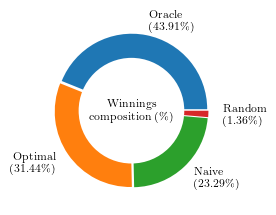

In [10]:
'''
Winning compositions
'''
get_winnings = np.vectorize(lambda x: 1*(not x.is_dead))
get_strategy = np.vectorize(lambda x: x.strategy)

pie_data = np.zeros(len(strategies_names)) 
for i,name in enumerate(strategies_names):
    for n in N:
        strategy_mask = get_strategy(mixed[n]) == name
        pie_data[i] += np.sum(strategy_mask*get_winnings(mixed[n]))
perc = 100 * pie_data / sum(pie_data)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, 0.7*FIG_HEIGHT))
labels = [f"{name.capitalize()} \n ({p:.2f}\%)" for name,p in zip(strategies_names,perc)]
ax.pie(
    pie_data, explode=[0.02]*len(strategies_names), 
    labels=labels, labeldistance=1.2, textprops={"fontsize":8}
)

# Add a white cirle to make a donought
# (https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.text(0,0,"Winnings \n composition (\%)", va="center", ha="center", fontsize=8)

plt.savefig("plot/pdf/pie.pdf", bbox_inches='tight')
plt.show(block=False)

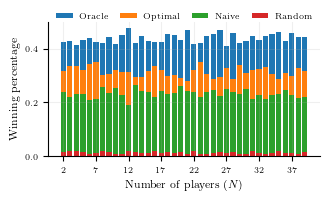

In [8]:
'''
Plotting winnings
'''

ratios = {name: np.zeros(len(N)) for name in strategies_names}
for n in N:
    winnings = get_winnings(mixed[n])
    strategy = get_strategy(mixed[n])
    for name in strategies_names:
        strategy_mask = strategy == name
        #strategy_occurrences = np.sum(strategy_mask)
        total_winnings    = np.sum(winnings)
        strategy_winnings = np.sum(strategy_mask*winnings)
        ratios[name][n-2] = strategy_winnings / total_winnings
        
fig, ax = plt.subplots(figsize=(FIG_WIDTH, 0.5*FIG_HEIGHT))
for ratio in ratios.values():
    plt.bar(np.arange(len(N)), ratio)
    
ax.grid(alpha=0.2)
plt.xticks(np.arange(0,len(N),5), np.arange(2,len(N),5), fontsize=6)
plt.yticks(fontsize=6)
ax.set_xlabel("Number of players ($N$)", fontsize=8)
ax.set_ylabel("Winning percentage", fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

labels = [name.capitalize() for name in strategies_names]
ax.legend(labels=labels, fontsize=6, frameon=False, loc="upper center", 
          mode="expand", ncol=4, bbox_to_anchor=(0., 1.02, 1., .102))

plt.savefig("plot/pdf/percentages.pdf", bbox_inches='tight')
plt.show(block=False)

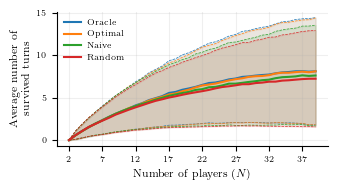

In [10]:
'''
Plot survived turns
'''

get_winners  = np.vectorize(lambda x: 1*(x.lives > 0))
get_turns    = np.vectorize(lambda x: x.turn)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, 0.5*FIG_HEIGHT))
for name,strategy in strategies.items():
    if name != "mixed":
        avg, std = np.zeros(len(N)), np.zeros(len(N))
        for n in N:
            turns = get_turns(strategy["results"][n])
            avg[n-2], std[n-2] = np.mean(turns), np.std(turns)    
    ax.fill_between(np.arange(len(N)), avg+std, avg-std, color=strategy["color"], alpha=0.1, zorder=0)
    ax.plot(avg, color=strategy["color"], label=name.capitalize())
    ax.plot(avg+std, color=strategy["color"], linewidth=0.5, linestyle="--")
    ax.plot(avg-std, color=strategy["color"], linewidth=0.5, linestyle="--")
    
ax.grid(alpha=0.2)
plt.xticks(np.arange(0,len(N),5), np.arange(2,len(N),5), fontsize=6)
plt.yticks(fontsize=6)
ax.set_xlabel("Number of players ($N$)", fontsize=8)
ax.set_ylabel("Average number of \n survived turns", fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=6, frameon=False)

plt.savefig("plot/pdf/survival.pdf", bbox_inches='tight')
plt.show(block=False)